The particle tracking step is put into a separate file, `tracking.py`, so that parallelization can be utilized (opposing to notebooks, where TrackPy parallelization resulted in error messages). To obtain datasets containing particle tracking information, run this file. The data is stored as binary files (ie. pickle files) which can be read by Pandas and then further analyzed. 

We start the data analyzis by importing some libraries and loading some metadata (ie. pixel per micron values).

In [1]:
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import trackpy as tp

metadata = json.load(open(f"metadata.json", "r"))

Then, some helper functions are defined.

In [2]:
def get_dataframe(sample, dataset):
    return pickle.load(
        open(f"data/processed_darkf_sample{sample}_0{dataset}_40x_5ms.pkl", "rb")
    )

In [3]:
def correct_drift(dataframe):
    d = tp.compute_drift(dataframe)
    tm = tp.subtract_drift(dataframe.copy(), d)
    return tm

In [4]:
def get_mpp(metadata, sample, dataset):
    ppms = metadata["pixel_per_micron"]
    denominator = ppms[f"processed_darkf_sample{sample}_0{dataset}_40x_5ms"]
    return 1 / denominator

We utilize the helper functions to load the particle tracking data from our binary files, correct drift and then store the data in a dictionary for later use.

In [5]:
dfs = {}
for i, sample in enumerate(["A", "B"]):
    for j in range(1, 4):
        df = get_dataframe(sample, j)
        tm = correct_drift(df)
        dfs.update({f"{sample}{j}": tm})

Plotting can be done as follows.

C:\Users\Trond\AppData\Local\Temp\ipykernel_43132\2823071633.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


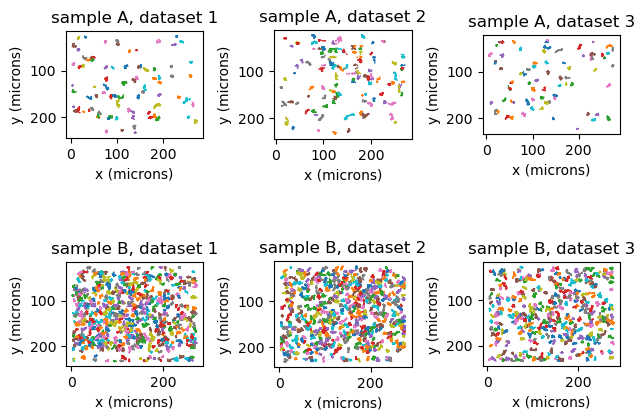

In [6]:
fig, axes = plt.subplots(2, 3)
for i, sample in enumerate(["A", "B"]):
    for j in range(1, 4):
        ax = tp.plot_traj(
            dfs[f"{sample}{j}"], ax=axes[i, j - 1], mpp=get_mpp(metadata, sample, j)
        )
        ax.set_title(f"sample {sample}, dataset {j}")
        ax.set_xlabel("x (microns)")
        ax.set_ylabel("y (microns)")
        ax.set_aspect("equal", adjustable="box")
fig.tight_layout()
fig.show()

To extract the results such as $A=4D$, we rune some utility functions from TrackPy one each of our datasets.

In [8]:
parameter_dataframes = []
for key in dfs.keys():
    em = tp.emsd(dfs[key], mpp=get_mpp(metadata, key[0], int(key[1])), fps=5)
    d = tp.utils.fit_powerlaw(em, plot=False)
    d.index = [key]
    parameter_dataframes.append(d)

parameter_dataframe = pd.concat(parameter_dataframes)

Printing the data in a nice table is easy...

In [9]:
parameter_dataframe

,n,A
A1,0.930923,2.168383
A2,0.986218,3.204035
A3,0.947677,2.185997
B1,0.879707,4.330082
B2,0.909479,3.824749
B3,0.885729,3.964606
